## Проект "Рекомендация тарифов"

В нашем распоряжении выборка данных о поведении клиентов, которые уже перешли на тарифные планы "Smart" и "Ultra". Нужно построить модель для задачи классификации, которая выберет подходящий тариф для клиентов которые еще находятся на архивных тарифных планах. Предобработка данных не понадобится — мы её уже сделали.

**Цель:** Построить модель категоризации с *accuracy* по крайней мере до 0.75. Проверить *accuracy* модели на тестовой выборке.

**Задачи:**

1. Открыть файл с данными и изучить его. Путь к файлу: /datasets/users_behavior.csv.
 
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки.

3. Исследовать качество разных моделей, меняя гиперпараметры. Сделать выводы по исследованию.

4. Проверить качество модели на тестовой выборке.

5. Проверить модель на вменяемость.

**Предмет исследования:** выборка данных по пользователям оператора «Мегалайна»

**Методы** которые мы применим в данном исследовании включают в себя: ознакомление и проверку данных, библиотеку "sklearn", обучение и проверку моделей.

**Структура проекта:** Проектная работа состоит из обзора и предобработки данных, затем следует разбивка данных на выборки, иссследование моделей, проверка моделей, проверка адекватности модели и общий вывод.

## Откройте и изучите файл

In [1]:
## Импорт библиотек

import pandas as pd
import numpy as np
import collections, numpy
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Откроем файл и запишем данные в пременную "df":

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

Выведем первые пять строк:

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Ознакомимся с общей информацией о датасете:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Нулевых и пропушенных значений не обнаружено.

Преобразуем типы данных в стобцах в цельночисленные, с округлением минут и сообщений до целых чисел, мегабайт до гигабайт, и переименуем столбец 'mb_used' в 'gb_used'.

In [5]:
df['calls'] = df['calls'].astype('int')
df['minutes'] = np.ceil(df['minutes']).astype('int')
df['messages'] = df['messages'].astype('int')
df['mb_used'] = np.ceil(df['mb_used'] / 1024).astype('int')

df.rename(columns={'mb_used': 'gb_used'}, inplace=True)

df.head()

,calls,minutes,messages,gb_used,is_ultra
0,40,312,83,20,0
1,85,517,56,23,0
2,77,468,86,21,0
3,106,746,81,9,1
4,66,419,1,15,0


Проверим на дубликаты:

In [6]:
df.duplicated().sum()

2

Две строки дублированы

In [7]:
df[df.duplicated(keep=False)]


,calls,minutes,messages,gb_used,is_ultra
540,2,2,0,1,1
1065,2,2,0,1,1
1821,16,102,0,3,0
2396,16,102,0,3,0


Удалим их

In [8]:
df = df.drop_duplicates()
df.shape

(3212, 5)

С значениями тоже все впорядке:

In [9]:
df.describe()

,calls,minutes,messages,gb_used,is_ultra
count,3212.000000,3212.000000,3212.000000,3212.000000,3212.000000
mean,63.072540,438.939913,38.305106,17.309465,0.306351
std,33.218875,234.459477,36.146950,7.391705,0.461049
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,275.000000,9.000000,13.000000,0.000000
50%,62.000000,431.000000,30.000000,17.000000,0.000000
75%,82.000000,573.000000,57.000000,21.000000,1.000000
max,244.000000,1633.000000,224.000000,49.000000,1.000000


А вот с классами не все так радужно - в нашем датасете присутсвует разбалансированность классов:

In [10]:
print(f"Количество строк в df['is_ultra'] по классам: {np.bincount(df['is_ultra'])}")

Количество строк в df['is_ultra'] по классам: [2228  984]


## Разбейте данные на выборки

Выделим признаки и целевое значение:

In [11]:
features = df.drop('is_ultra', axis=1)  # features: содержит признаки
target = df['is_ultra']  # features: содержит целевой показатель

Разделим наш датасет на обучающую, валидационную и тестовую - выборки, в два этапа: сначала 60/40, затем 50/50

In [33]:
features_train, features_test, target_train, target_test = train_test_split( # 60/40
    features, target, test_size=0.6, random_state=12345, stratify=target)

print(f"Количество строк в target_train по классам: {np.bincount(target_train)}")
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

features_valid, features_test, target_valid, target_test = train_test_split( # 50/50 или 12.5 и 12.5 от 25%)
    features_test, target_test, test_size=0.5, random_state=12345, stratify=target_test)

print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}")

Количество строк в target_train по классам: [891 393]
Количество строк в target_test по классам: [1337  591]
Количество строк в target_test по классам: [669 295]
Количество строк в target_valid по классам: [668 296]


## Исследуйте модели

Мы будем обучать три модели: **LogisticRegression**, **DecisionTreeClassifier**, **RandomForestClassifier** и проверять на валидационной выборке. Для определения оптимальных парметров настройки моделей используем **GridSearchCV**:

### LogisticRegression

In [73]:
%%time
scaler = StandardScaler() # Модель StandardScaler() поместим в переменную scaler
logistic = LogisticRegression() # Модель StandardScaler() поместим в переменную logistic

pipe = Pipeline(steps=[("scaler", scaler), ("logistic", logistic)]) # Создаем пайплайн с двумя шагами

 # Задаем решетку параметров пайплайна
param_grid = {'logistic__penalty': ['l1', 'l2'],
              'logistic__C': np.logspace(-2, 2, 20),
              'logistic__solver': ['liblinear'],
              'logistic__max_iter': list(range(400, 800, 100)),
              'logistic__random_state':[123456]}

 # Создаем нашу модель и передаем ей пайплайн, решетку параметров, также используем кросс-валидацию результата
grid_search_cv_lr = GridSearchCV(pipe, param_grid, cv=5)

 # Обучаем модель на тренировочной части выборки:
grid_search_cv_lr.fit(features_train, target_train)

best_params_lr = grid_search_cv_lr.best_params_ # Лучшие параметры
best_lr = grid_search_cv_lr.best_estimator_ # Лучшая модель
best_lr_score = grid_search_cv_lr.best_score_ # Лучший результат

print(f'Точность модели {logistic} на тренировочной выборке составила: \
    {best_lr_score} с параметрами \
    {best_params_lr}')

Точность модели LogisticRegression() на тренировочной выборке составила:     0.7616822714007782 с параметрами     {'logistic__C': 0.01, 'logistic__max_iter': 400, 'logistic__penalty': 'l2', 'logistic__random_state': 123456, 'logistic__solver': 'liblinear'}


### DecisionTreeClassifier

In [74]:
%%time
dtc = tree.DecisionTreeClassifier() # Модель DecisionTreeClassifier() поместим в переменную dtc

pipe = Pipeline(steps=[("scaler", scaler), ("dtc", dtc)]) # Создаем пайплайн с двумя шагами

 # Задаем решетку параметров пайплайна
param_grid =  {'dtc__max_depth': list(range(1, 15)),
              'dtc__min_samples_split': list(range(18, 22)),
              'dtc__min_samples_leaf': list(range(3, 5)),
              'dtc__criterion': ['entropy'],
              'dtc__splitter': ['random'],
             'dtc__random_state':[123456]}


 # Создаем нашу модель и передаем ей пайплайн, решетку параметров, также используем кросс-валидацию результата    
grid_search_cv_dtc = GridSearchCV(pipe, param_grid, n_jobs=2)

 # Обучаем модель на тренировочной части выборки:
grid_search_cv_dtc.fit(features_train, target_train)

best_params_dtc = grid_search_cv_dtc.best_params_ # Лучшие параметры
best_dtc = grid_search_cv_dtc.best_estimator_ # Лучшая модель
best_dtc_score = grid_search_cv_dtc.best_score_ # Лучший результат

print(f'Точность модели {dtc} на тренировочной выборке составила: \
    {best_dtc_score} с параметрами \
    {best_params_dtc}')

Точность модели DecisionTreeClassifier() на тренировочной выборке составила:     0.7959508754863813 с параметрами     {'dtc__criterion': 'entropy', 'dtc__max_depth': 10, 'dtc__min_samples_leaf': 3, 'dtc__min_samples_split': 19, 'dtc__random_state': 123456, 'dtc__splitter': 'random'}


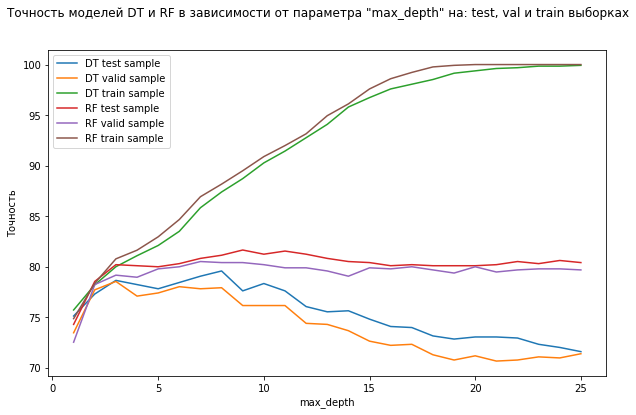

In [37]:
%%time
max_depth = 25

deth_list = []

score_list_dt_test = []
score_list_dt_val = []
score_list_dt_train = []

score_list_rf_test = []
score_list_rf_val = []
score_list_rf_train = []

fig, ax = plt.subplots(1, figsize=(10, 6))

ax.set_ylabel('Точность')
ax.set_xlabel('max_depth')


for depth in range(1, max_depth + 1):
    deth_list.append(depth)
    
    model_dt = tree.DecisionTreeClassifier(max_depth=depth, random_state=123456)
    model_dt.fit(features_train, target_train)
    
    predictions_model_dt = model_dt.predict(features_train)
    model_dt_score = accuracy_score(target_train, predictions_model_dt)
    score_list_dt_train.append(round(model_dt_score * 100, 3))
    
    predictions_model_dt = model_dt.predict(features_valid)
    model_dt_score = accuracy_score(target_valid, predictions_model_dt)
    score_list_dt_val.append(round(model_dt_score * 100, 3))
    
    predictions_model_dt = model_dt.predict(features_test)
    model_dt_score = accuracy_score(target_test, predictions_model_dt)
    score_list_dt_test.append(round(model_dt_score * 100, 3))
    

    
    model_rf = RandomForestClassifier(max_depth=depth, random_state=123456)
    model_rf.fit(features_train, target_train)
    
    predictions_model_rf = model_rf.predict(features_train)
    model_rf_score = accuracy_score(target_train, predictions_model_rf)
    score_list_rf_train.append(round(model_rf_score * 100, 3))
    
    predictions_model_rf = model_rf.predict(features_valid)
    model_rf_score = accuracy_score(target_valid, predictions_model_rf)
    score_list_rf_val.append(round(model_rf_score * 100, 3))

    
    predictions_model_rf = model_rf.predict(features_test)
    model_rf_score = accuracy_score(target_test, predictions_model_rf)
    score_list_rf_test.append(round(model_rf_score * 100, 3))
    
    

ax.plot(deth_list, score_list_dt_test, label="DT test sample");
ax.plot(deth_list, score_list_dt_val, label="DT valid sample");
ax.plot(deth_list, score_list_dt_train, label="DT train sample");
ax.plot(deth_list, score_list_rf_test, label="RF test sample");
ax.plot(deth_list, score_list_rf_val, label="RF valid sample");
ax.plot(deth_list, score_list_rf_train, label="RF train sample");

ax.legend()
fig.suptitle('Точность моделей DT и RF в зависимости от параметра "max_depth" на: test, val и train выборках');   

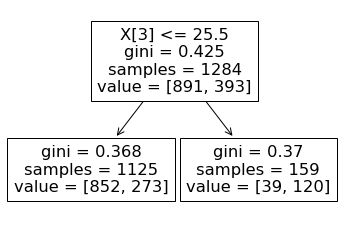

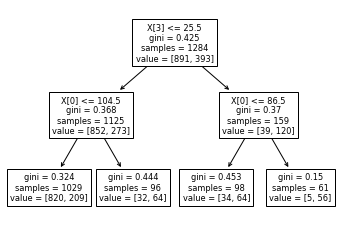

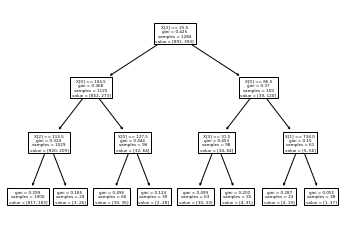

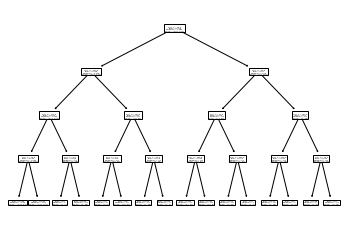

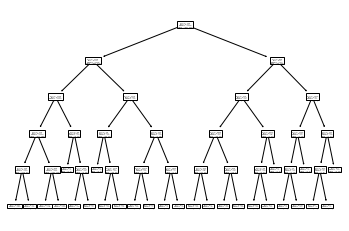

In [18]:
max_depth = 5

for depth in range(1, max_depth + 1):
    model = tree.DecisionTreeClassifier(max_depth=depth)
    model.fit(features_train, target_train)
    tree.plot_tree(model)
    plt.show()

### RandomForestClassifier

In [21]:
%%time

rfc = RandomForestClassifier() # Модель RandomForestClassifier() поместим в переменную rfc

pipe = Pipeline(steps=[("scaler", scaler), ("rfc", rfc)]) # Создаем пайплайн с двумя шагами

 # Задаем решетку параметров пайплайна
param_grid =  {'rfc__n_estimators': range(90, 100, 5), 
              'rfc__max_depth': list(range(9, 12)), 
              'rfc__bootstrap': [True, False], 
              'rfc__criterion': ['gini'],
             'rfc__random_state':[123456]}


 # Создаем нашу модель и передаем ей пайплайн, решетку параметров, также используем кросс-валидацию результата    
grid_search_cv_rfc = GridSearchCV(pipe, param_grid, n_jobs=2)

 # Обучаем модель на тренировочной части выборки:
grid_search_cv_rfc.fit(features_train, target_train)

best_params_rfc = grid_search_cv_rfc.best_params_ # Лучшие параметры
best_rfc = grid_search_cv_rfc.best_estimator_ # Лучшая модель
best_rfc_score = grid_search_cv_rfc.best_score_ # Лучший результат
print(f'Точность модели {rfc} на тренировочной выборке составила: \
    {best_rfc_score} с параметрами \
    {best_params_rfc}')

Точность модели RandomForestClassifier() на тренировочной выборке составила:     0.7858341439688716 с параметрами     {'rfc__bootstrap': True, 'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__n_estimators': 90, 'rfc__random_state': 123456}
CPU times: user 337 ms, sys: 16.1 ms, total: 353 ms
Wall time: 16.4 s


In [22]:
# Создадим словарь где ключами будут являться имена моделей, а значениями результаты на "valid" выборке для выбора лучшей модели
model_dict = {}

predictions_lr = best_lr.predict(features_valid) # Предсказания модели LogisticRegression() на "valid" выборке
predictions_dtc = best_dtc.predict(features_valid) # Предсказания модели DecisionTreeClassifier() на "valid" выборке
predictions_rfc = best_rfc.predict(features_valid) # Предсказания модели RandomForestClassifier() на "valid" выборке

predictions_lr_score = accuracy_score(target_valid, predictions_lr) # Результат LogisticRegression()
model_dict[type(best_lr[1]).__name__] = round(predictions_lr_score * 100, 2) 

accuracy_dtc_score = accuracy_score(target_valid, predictions_dtc) # Результат DecisionTreeClassifier()
model_dict[type(best_dtc[1]).__name__] = round(accuracy_dtc_score * 100, 2)

accuracy_rfc_score = accuracy_score(target_valid, predictions_rfc) # Результат RandomForestClassifier()
model_dict[type(best_rfc[1]).__name__] = round(accuracy_rfc_score * 100, 2)

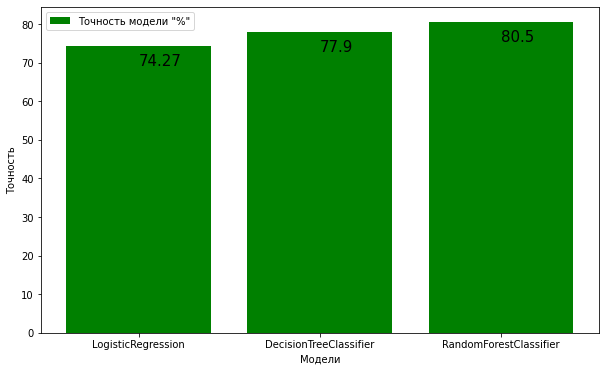

In [75]:
names = list(model_dict.keys()) # Имена моделей поместим в список "names"
values = list(model_dict.values()) # Результаты моделей поместим в список "values"

fig, ax = plt.subplots(1, figsize=(10, 6), sharey=True)

for i in range(len(names)): # Текстовые подписи на графике
    ax.text(names[i], values[i]-5, values[i], fontsize=15)
    
ax.set_ylabel('Точность') # Подписи осей
ax.set_xlabel('Модели')

ax.bar(names, values, label='Точность модели "%"', color=['green']) # Отрисовка

ax.legend();# Легенда

## Проверьте модель на тестовой выборке

Проверим ранее обученные модели на тестовой выборке, имя модели и результаты тестирования поместим в словарь model_dict для дальнейшего сравнения точностей моделей:

In [80]:
predictions_rfc = best_rfc.predict(features_test) # прогноз наилучшей модели RandomForestClassifier()
accuracy_rfc_score = accuracy_score(target_test, predictions_rfc) # Точность
print(f'Точность модели {best_rfc} на тестовой выборке составила: {round(accuracy_rfc_score*100, 2)}')


Точность модели Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc',
                 RandomForestClassifier(max_depth=9, n_estimators=90,
                                        random_state=123456))]) на тестовой выборке составила: 81.54


Модель **RandomForestClassifier** показала результат 81.54 % на тестовой выборке

## (бонус) Проверьте модели на адекватность

In [106]:
model_dc = DummyClassifier(strategy='uniform', random_state=0)
model_dc.fit(features_train, target_train)
predictions_model_dc = model_dc.predict(features_test)
model_dc_score = accuracy_score(target_test, predictions_model_dc)
print(f'Точность рандомной модели на тестовой выборке составила: {round(model_dc_score*100,2)}%')

print(f'Классы на тестовой выборке модели DummyClassifier() {collections.Counter(predictions_model_dc)}')  
print(f'Классы на тестовой выборке модели RandomForestClassifier() {collections.Counter(predictions_rfc)}')  
print(f'Классы тестовой выборки {collections.Counter(target_train)}')  

Точность рандомной модели на тестовой выборке составила: 49.9%
Классы на тестовой выборке модели DummyClassifier() Counter({1: 492, 0: 472})
Классы на тестовой выборке модели RandomForestClassifier() Counter({0: 781, 1: 183})
Классы тестовой выборки Counter({0: 891, 1: 393})


DummyClassifier() он же фиктивный классификатор, в нашем случае является маркером неадекватности модели, в выборке данных у нас присутсвует дисбаланс классов - это второй индикатор адекватности т.к. в прогнозе адекватной можели также должен присутствовать дисбаланс. У модели RandomForestClassifier() как раз этот дисбаланс виден в прогнозе, поэтому наша модель вполне адекватна.

**Общий вывод:** Мы ознакомились с датасетом, затем привели данные к нужным типам и округлили их. Разбили наш датасет на обучающую, валидационную и тестовую выборки. 

Мы использовали в нашем проекте три модели: **LogisticRegression**, **DecisionTreeClassifier**, **RandomForestClassifier**, применив метод перебора параметров Pipeline + GridSearchCV нам удалось достичь точность в: **74.27, 77.9, 80.5** процентов на валидационной выборке соответственно. 

Модель **RandomForestClassifier**  параметрами {'rfc__bootstrap': True, 'rfc__criterion': 'gini', 'rfc__max_depth': 9, 'rfc__n_estimators': 90, 'rfc__random_state': 123456} показала результат 81.5 % на тестовой выборке

DummyClassifier() он же фиктивный классификатор, в нашем случае является маркером неадекватности модели, в выборке данных у нас присутсвует дисбаланс классов - это второй индикатор адекватности т.к. в прогнозе адекватной можели также должен присутствовать дисбаланс. У модели RandomForestClassifier() как раз этот дисбаланс виден в прогнозе, поэтому наша модель вполне адекватна.